# Hic Heatmap anylsis
This is the progress of the HIC heatmap project so far, building a class called heatmap analysis, which contains some methods for generating the heatmap itself, as well as methods for processing and analyzing the two-dimensional arrays that make up the heatmap

In [38]:
%config InlineBackend.figure_format = 'svg'
import re
import json
import numpy as np
import pandas as pd
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import chromosight.utils.contacts_map as mapp
from IPython.display import display
import chromosight.utils.io as io
%matplotlib inline
from scipy.signal import find_peaks
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.transform import resize
from skimage import data, img_as_float
import cv2
from operator import itemgetter
from findpeaks import findpeaks
from scipy import signal
from hic2cool import hic2cool_convert
import networkx as nx


In [39]:
import matplotlib.pyplot as plt

In [40]:
fish.get_score_column(new_dict)

peak detection by column 231


In [41]:
cooler

<module 'cooler' from '/home/hraaxl/.local/lib/python3.7/site-packages/cooler/__init__.py'>

# Class that use for heatmap anylsis
   ## __heatmap_anylsis(path)__:  
   #### *paramater* :  
   __path__: The .cool file path input(if use .mcool file rather than .cool file, need to choose resolution by add "::/resolutions/{resolution value} " after path, resolutions value can only choose from {1000,5000,10000,25000,50000,100000,250000,500000,1000000,2500000}, The smaller the value, the more detailed the matrix and the image.）  
   ## function:

   ### -readcool() :  

   use cooler package generate cooler api  
   #### paramater :  
   Nah, will use path that input in heatmap_anylsis  
   #### return :  
   cooler.api.Cooler  
     
   ### -getmatrix():  
   will get heatmap matrix(not a matrix with value between 0-255)  
   #### paramater__ :  
   Nah   
   #### return:  
   A 2D array which use to generate the heatmap(The matrix build with origion data in .cool file rather than with value         between 0-255)  
     
   ### -generatemap(matrix,size = (8,8)):  
   will generate image use the right color and shade    
   #### paramater :  
   __matrix__: A 2D array as input  
   __size__:A tuple with 2 value that represent image size as input, default (8,8)  
   #### return :  
   Generate the image  
   
   ### -generatemap2(matrix,size = (8,8)):  
   will generate image and resize those image which has very small width    
   #### paramater :  
   __matrix__: A 2D array as input  
   __size__:A tuple with 2 value that represent image size as input, default (8,8)  
   #### return :  
   Generate the image  

   ### -bins_info():  
   will generate dataframe containing bin related informations(start,end position and nomalization information)     
   #### paramater :  
   nah  
   #### return :  
   dataframe include related informations  
   
   ### -chro_info():  
   will generate dataframe containing chromosome information. Each row contains the name, length, first and last bin of a chromosome.
   
   #### paramater :  
   nah  
   #### return :  
   dataframe include related informations  
   
   ### -thansfer_bin_to_list(list_type='start_list'):  
   will thransfer bin start and end location from dataframe to list,thansfer_bin_to_list(choro_frame)[0] represent start
list and thansfer_bin_to_list(choro_frame)[1] represent end list     
   #### paramater :  
   __list_type__: choose from {'start_list','end_list'}, default 'start_list'
   #### return :  
   A list contain start_bin location or end_bin location
   
     
     
    

In [ ]:
type((8,8))

In [95]:
#path: The .cool file path input(if use .mcool file rather than .cool file, need to choose 
#resolution by add "::/resolutions/{resolution value} " after path, resolutions value can only
#choose from {1000,5000,10000,25000,50000,100000,250000,500000,1000000,2500000}, The smaller 
#the value, the more detailed the matrix and the image.）
class heatmap_anylsis:
    
    def __init__(self,path):
        self.path = path
        
#use cooler package generate cooler api  
# will return cooler.api.cooler 
    def readcool(self):
        new_cool = cooler.Cooler(self.path)
        return new_cool
    
## Converting imported .cool files into two-dimensional arrays    
    def getmatrix(self,value = False):
        new_cool = cooler.Cooler(self.path)
        new_matrix = new_cool.matrix(sparse=False, balance=value)[:]
        return new_matrix
    
    
    def generatemap(self,matrix,size = (8,8)):
        plt.figure(figsize=size)
        plt.imshow(matrix ** 0.02, cmap='afmhot_r',norm=colors.PowerNorm(gamma=0.45))

    
## generate heatmap from matrix(two-dimensional arrays)  
    def generatemap2(self,matrix,size = (8,8)):
        plt.figure(figsize=size)
        if matrix.shape[0] < 200:
            matrix_c = matrix.copy()
            matrix_c = resize(matrix_c, (250,matrix.shape[1]))
            plt.imshow(matrix_c, cmap='afmhot_r',norm=colors.PowerNorm(gamma=0.15))
            plt.axis('off')
        else:
            plt.imshow(matrix ** 0.02, cmap='afmhot_r',norm=colors.PowerNorm(gamma=0.45))
            plt.axis('off')
    
## Table containing bin related informations(start,end position and nomalization information)        
    def bins_info(self):
        all_info = mapp.HicGenome(self.path)
        bin_info = all_info.bins
        return bin_info
    
## Table of chromosome information. Each row contains the name, length, first and last bin of a chromosome.    
    def chro_info(self):
        table_c = io.load_cool(self.path)
        return table_c[1]
    
## thransfer bin start and end location from dataframe to list  
    def thansfer_bin_to_list(self,list_type='start_list'):
        choro_frame = self.chro_info()
        bin_loc = choro_frame.iloc[:,2:4]
        start_bin = bin_loc.iloc[:,0]
        end_bin = bin_loc.iloc[:,1]
        start_list = start_bin.values.tolist()
        end_list = end_bin.values.tolist()
        if list_type == 'start_list':
            return start_list
        elif list_type == 'end_list':
            return end_list
        else:
            print('Please input "start_list" or "end_list" to choose list type')
            
## split matrix by each contig row(use range of bins i.e. range from start bin to end bin, generate each contig row matrix, also will return a dictionary
## related contig id to matrix
    def split_matrix(self,rtype = 'list'):
        n_list=[]
        n_dic = {}
        chro_info = self.chro_info()
        z = chro_info.iloc[:,0]
        z = z.values.tolist()
        start_list = self.thansfer_bin_to_list()
        end_list =self.thansfer_bin_to_list('end_list')
        image = self.getmatrix()
        for i in range(len(start_list)):
            row = image[start_list[i]:end_list[i],:]
            n_dic[z[i]] = row
            n_list.append(row)
        if rtype == 'list':
            return n_list
        elif rtype == 'dic':
            return n_dic
        
## remove array from list       
    def removearray(self,List,arr):
        ind = 0
        size = len(List)
        while ind != size and not np.array_equal(List[ind],arr):
            ind += 1
        if ind != size:
            List.pop(ind)
        else:
            raise ValueError('array not found in list.')
            
    def get_contig_id(self,matrix,my_dict):
        for key, value in my_dict.items():
            if np.array_equal(value,matrix):
                return key
 
        return "key doesn't exist"

## get contig id from matrix that interested
    def sort_matrix(self):
        matrix_list = self.split_matrix()
        m_list = []
        c_list = matrix_list.copy()
        for i in matrix_list:
            m_list.append(i.shape[0])
            m_list.sort()
        sorted_list = []
        for i in m_list:
            for j in c_list:
                if j.shape[0] == i:
                    sorted_list.append(j)
                    removearray(c_list,j)
                    break    
        return sorted_list
    
    def remove_contig_length(self,length):
        chrom_info = self.chro_info() 
        splited_matrix = self.split_matrix()
        length_list = chrom_info.iloc[:,1].values.tolist() #length list
        list1 = []
        for i in length_list:
            if i >=length: 
                list1.append(i)
        list_index = []
        for i in range(len(length_list)):
            for j in list1:
                if length_list[i] == j:
                    list_index.append(i)
        list_new = []
        for i in list_index:
            list_new.append(splited_matrix[i])
        return list_new
    
## show peak diagram for contig matrix(cannot use this function to whole heatmap)
    def peak_dia(self,contig_matrix):
        plt.plot(contig_matrix.T)
        plt.show()
    
    def find_location(self,p_index,dic,matrix,choro_frame):
        bin_loc = choro_frame.iloc[:,2:4] #get start_bin and end_bin dataframe
        start_bin = bin_loc.iloc[:,0]# change to list
        end_bin = bin_loc.iloc[:,1]# change to list
        for i in range(len(start_bin)):
            if p_index >= start_bin[i] and p_index < end_bin[i]:  #  if input index larger or equel to start bin and less than end bin         
                idd = self.get_contig_id(matrix[start_bin[i]:end_bin[i],:],dic)#extract 2D array betwwen start_bin and end_bin and use dictionary find contig id
        return idd
    
    def get_peak_dic(self,splited_matrix):
        dic_n = {}
        for i in splited_matrix:
            i_mean = np.mean(i,axis = 0)
            median_height = np.median(smooth_scaffold(i_mean))
            peaks, _ = find_peaks(smooth_scaffold(i_mean), height = median_height*4.5, distance = 110)
            dic_n[get_contig_id(i,fish_dic)] = peaks
        return dic_n,peaks
    
    def smooth_scaffold(self,scaffold, window_length=10):
        return np.convolve(scaffold, np.ones(window_length)/window_length, mode='same')
    
    def peak_plot(self,splited_matrix):
        list_p = []
        for i in splited_matrix:
            i_mean = np.mean(i,axis = 0)
            median_height = np.median(self.smooth_scaffold(i_mean))
            peaks, _ = find_peaks(self.smooth_scaffold(i_mean), height = median_height*4, distance = 110)
            list_p.append(len(peaks))
        new_dic = {}
        for j in range(35):
            count = 0
            for i in list_p:
                if i == j:
                    count = count + 1
            new_dic[j] = count
    
        lists = sorted(new_dic.items()) # sorted by key, return a list of tuples

        x, y = zip(*lists) # unpack a list of pairs into two tuples

        plt.plot(x, y)
        plt.show()
        return new_dic
    
    
    def generate_peak(self,matrix,dic):
        matrix_mean = np.mean(matrix,axis = 0)
        median_height = np.median(self.smooth_scaffold(matrix_mean))
        peaks, _ = find_peaks(self.smooth_scaffold(matrix_mean), height = median_height*4, distance = 110,plateau_size = 1)
        right = _.get('right_edges')
        for i in peaks:
            idd = self.get_contig_id(matrix,dic)
            image = matrix
            if image.shape[0] < 200:
                image = resize(image, (250, image.shape[1]))
            plt.imshow(image ** 0.02, cmap='afmhot_r',norm=colors.PowerNorm(gamma=0.45))
            plt.plot(i,125,marker='.',color = 'green')
            plt.axis('off')
            plt.title(str(idd) + ', ' + str(i))
            plt.show()
            
            
            
    def get_ids(self,matrix,big_matrix,dic,choro_frame):
        matrix_mean = np.mean(matrix,axis = 0)
        median_height = np.median(self.smooth_scaffold(matrix_mean))
        peaks, _ = find_peaks(self.smooth_scaffold(matrix_mean), height = median_height * 4, distance = 110,plateau_size = 1)
        left = _.get('left_edges')
        iddd = self.get_contig_id(matrix,dic)
        idd_list = []
        new_dic = {}
        for i in peaks:
            idd = self.find_location(i,dic,big_matrix,choro_frame)
            idd_list.append(idd)
        new_dic[iddd] = set(idd_list)
        return new_dic
    
    def get_ids_after_filter(self,matrix,big_matrix,dic,choro_frame):
        matrix_mean = np.mean(matrix,axis = 0)
        median_height = np.median(self.smooth_scaffold(matrix_mean))
        peaks, _ = find_peaks(self.smooth_scaffold(matrix_mean), height = median_height * 3, distance = 110,plateau_size = 1)
        left = _.get('left_edges')
        iddd = self.get_contig_id(matrix,dic)
        idd_list = []
        new_dic = {}
        for i in peaks:
            idd = self.find_location(i,dic,big_matrix,choro_frame)
            contig = dic.get(idd)
            length = self.get_length(contig,dic,'length')
            if length >= 500000:
                idd_list.append(idd)
        new_dic[iddd] = set(idd_list)
        return new_dic
    
    def get_ids_dict_af(self,splited_matrix,dic):
        new_dict = {}
        fish_mat = self.getmatrix()
        info = self.chro_info()
        for i in splited_matrix:
            mnn = self.get_ids_after_filter(i,fish_mat,dic,info) # find peaks and get contig id, also will get contig id for all contigs which related to that contig
            new_dict.update(mnn)
        return new_dict
    
    def get_ids_dict(self,splited_matrix,dic):
        new_dict = {}
        fish_mat = self.getmatrix()
        info = self.chro_info()
        for i in splited_matrix:
            mnn = self.get_ids(i,fish_mat,dic,info) # find peaks and get contig id, also will get contig id for all contigs which related to that contig
            new_dict.update(mnn)
        return new_dict
    
    def get_score_column(self,dic):
        score = 0
        for key,values in dic.items():
            for i in values:
                matrix = all_dic.get(i)
                result = self.get_ids(matrix,fish_mat,all_dic,info)
                for d in result.values():
                    if key in d:
                        score = score + 1

        print('peak detection by column',score)  
        
    def optimize_result(self,dic):
        nnn_dic = {}
        for key,values in dic.items():
            listt = []
            for i in values:
                matrix = all_dic.get(i)
                result = self.get_ids(matrix,fish_mat,all_dic,info)
                for d in result.values():
                    if key in d:
                        listt.append(i)
            nnn_dic[key] = listt
        return nnn_dic
    

            
    def get_length(self,contig,dic,dtype = 'bin'):
        fish_chro_info = self.chro_info()
        chro_info = self.chro_info()
        z = chro_info.iloc[:,0]
        z = z.values.tolist()
        bin_loc = chro_info.iloc[:,2:4] #get start_bin and end_bin dataframe
        start_bin = bin_loc.iloc[:,0]# change to list
        end_bin = bin_loc.iloc[:,1]
        pp = 0
        for i in range(len(z)):
            if z[i] == str(self.get_contig_id(contig,dic)):
                pp = i
        length_list = fish_chro_info.iloc[:,1].values.tolist()#length list
        if dtype == 'length':
            return length_list[pp]
        elif dtype == 'bin':
            return start_bin[pp],end_bin[pp]
        else:
            return z[pp]

    
    
    

In [43]:
np.ones(10)/10

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [44]:
def l_n_scatter(dic):
    ne_dic = {}
    for i in range(13):
        new_list = []
        for key,values in dic.items():
            if len(values) == i:            
                new_list.append(fish.get_length(all_dic.get(key),all_dic,'length'))
            ne_dic[i] = new_list
    
    fig, ax = plt.subplots()

    for x, ys in ne_dic.items():
        try:
            ax.scatter([x] * len(ys), ys,6)
        except ValueError:  #raised if `y` is empty.
            pass

    plt.show()

In [45]:
def get_ids(self,matrix,big_matrix,dic,choro_frame):
    matrix_mean = np.mean(matrix,axis = 0)
    median_height = np.median(self.smooth_scaffold(matrix_mean))
    peaks, _ = find_peaks(self.smooth_scaffold(matrix_mean), height = median_height * 4, distance = 110,plateau_size = 1)
    left = _.get('left_edges')
    iddd = self.get_contig_id(matrix,dic)
    idd_list = []
    new_dic = {}
    for i in peaks:
        idd = self.find_location(i,dic,big_matrix,choro_frame)
        idd_list.append(idd)
    new_dic[iddd] = set(idd_list)
    return new_dic

In [46]:
def get_contig_id(matrix,my_dict):
        for key, value in my_dict.items():
            if np.array_equal(value,matrix):
                return key
 
        return "key doesn't exist"

In [47]:
def get_length(contig,dic,dtype = 'bin'):
    fish_chro_info = info
    chro_info = info
    z = chro_info.iloc[:,0]
    z = z.values.tolist()
    bin_loc = chro_info.iloc[:,2:4] #get start_bin and end_bin dataframe
    start_bin = bin_loc.iloc[:,0]# change to list
    end_bin = bin_loc.iloc[:,1]
    pp = 0
    for i in range(len(z)):
        if z[i] == str(fish.get_contig_id(contig,dic)):
            pp = i
    length_list = fish_chro_info.iloc[:,1].values.tolist()#length list
    if dtype == 'length':
        return length_list[pp]
    elif dtype == 'bin':
        return start_bin[pp],end_bin[pp]
    else:
        return z[pp]

In [48]:
def generate_peak(dic):
    for key,values in dic.items():
        matrix = all_dic.get(key)
        for i in values:
            matrixs = all_dic.get(i)
            position = get_length(matrixs,all_dic,'bin')[0]
            if matrix.shape[0] < 200:
                lop = resize(matrix, (250, matrix.shape[1]))
            plt.imshow(lop ** 0.02, cmap='afmhot_r',norm=colors.PowerNorm(gamma=0.45))
            plt.plot(position,125,marker='.',color = 'green')
            plt.axis('off')
            plt.title(str(key) + ', ' + str(i) )
            plt.show()

In [49]:
 def peak_plot(dic):
        
        list_p = []
        
        for i in dic.values():
            length = len(i)
            list_p.append(length)
        new_dic = {}
        for j in range(35):
            count = 0
            for i in list_p:
                if i == j:
                    count = count + 1
            new_dic[j] = count
    
        lists = sorted(new_dic.items()) # sorted by key, return a list of tuples

        x, y = zip(*lists) # unpack a list of pairs into two tuples

        plt.plot(x, y)
        plt.xlabel('number of peaks')
        plt.ylabel('number of contigs')

        plt.show()
        return new_dic

In [50]:
def sift(gray,img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(gray,None)
    img = cv2.drawKeypoints(gray,kp,img)
    return img
def show(src):
    src = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
    plt.imshow(src)
def threshold(img,x):
    ret, thresh = cv2.threshold(img,x,255,cv2.THRESH_BINARY)
    return thresh
def get_ids_cwd(matrix,big_matrix,dic,choro_frame):
    matrix_mean = np.mean(matrix,axis = 0)
    median_height = np.median(smooth_scaffold(matrix_mean))
    peakind = signal.find_peaks_cwt(matrix_mean, np.arange(1,150))
    iddd = get_contig_id(matrix,dic)
    for i in peakind:
        idd = find_location(big_matrix,choro_frame,dic,i)
        print(iddd ,i, idd)
    

In [51]:
def find_ids_contig(matrix,chro_info):
    z = chro_info.iloc[:,0]
    bin_loc = chro_info.iloc[:,2:4]
    start_bin = bin_loc.iloc[:,0]
    end_bin = bin_loc.iloc[:,1]
    start = start_bin.values.tolist()
    end = end_bin.values.tolist()
    dd = []
    for j in range(len(start)):
        if len(dd)>565:
            dd.clear
        matrixs = matrix[: , start[j]:end[j]]
        dd.append(matrixs.mean())
    ipo = []
    mean = np.mean(dd)
    peaks, _ = find_peaks(dd,height = mean * 4)
    for i in peaks:
        ipo.append(z[i])
    return ipo

In [52]:
def find_ids_contig_s(matrix,chro_info):
    z = chro_info.iloc[:,0]
    bin_loc = chro_info.iloc[:,2:4]
    start_bin = bin_loc.iloc[:,0]
    end_bin = bin_loc.iloc[:,1]
    start = start_bin.values.tolist()
    end = end_bin.values.tolist()
    dd = []
    for j in range(len(start)):
        if len(dd)>565:
            dd.clear
        matrixs = ndi.filters.gaussian_filter(matrix[: , start[j]:end[j]],(3,3))
        dd.append(matrixs.mean())
    ipo = []
    mean = np.mean(dd)
    peaks, _ = find_peaks(dd,height = mean /10)
    for i in peaks:
        ipo.append(z[i])
    return ipo

In [53]:
def find_ids_contig_r(matrix,chro_info):
    z = chro_info.iloc[:,0]
    bin_loc = chro_info.iloc[:,2:4]
    start_bin = bin_loc.iloc[:,0]
    end_bin = bin_loc.iloc[:,1]
    start = start_bin.values.tolist()
    end = end_bin.values.tolist()
    dd = []
    for j in range(len(start)):
        if len(new_ll)>565:
            new_ll.clear
        matrixs = matrix[: , start[j]:end[j]]
        dd.append(matrixs.mean())
    ipo = []
    mean = np.mean(dd)
    peaks, _ = find_peaks(dd,height = mean * 3)
    for i in peaks:
        matrix = all_dic.get(z[j])
        length = get_length(matrix,all_dic,dtype = 'length')
        if length >= 500000:
            ipo.append(z[j])
    return ipo

In [54]:
def net_graph(dic):
    
    a_dic = {}
    for key,values in dic.items():
        a_list = []
        new_key = key[0:-12]
        for i in values:
            i = i[0:-12]
            a_list.append(i)
        a_dic[new_key] = a_list
        
    G = nx.Graph()
    G.add_nodes_from(a_dic.keys())
    for key,values in a_dic.items():
        if len(values) == 1:
            continue
        vote_strength = 1/(len(values)-1)
        for contig in values:
            if contig != key:
                G.add_edge(key,contig)
    nx.draw_spring(G,node_size = 5)

In [55]:
def get_score_contig(dic,info):
    score = 0
    for key,values in dic.items():
        for i in values:
            matrix = all_dic.get(i)
            result = find_ids_contig(matrix,info)
            if key in result:
                score = score + 1
    print('peak detection by contig',score)  

In [56]:
def merge_contig(id_list,info,all_dic):
    new_list = []
    new_list1 = []
    length = len(id_list)
    for i in range(length):
        matrix = all_dic.get(id_list[i])
        c_length = get_length(matrix,all_dic,info)
        new_list.append(matrix)
        new_list1.append(c_length)
    labels =np.concatenate(new_list, axis=0)
    another_list = []
    for i in new_list1:
        x = labels[:,i[0]:i[1]]
        another_list.append(x)
    labelss =np.concatenate(another_list, axis=1)
    plt.imshow(labelss ** 0.02, cmap='afmhot_r',norm=colors.PowerNorm(gamma=0.45))

In [57]:
def get_score_contig_after_filter(dic):
    score = 0
    for key,values in dic.items():
        for i in values:
            result = dic.get(i)
            if key in result:
                score = score + 1
    print('peak detection by contig after filter 500000',score)  

In [58]:
def sort_by_contig(chro_info,splitted_matrix,dic):
    jkll = {}
    z = chro_info.iloc[:,0]
    bin_loc = chro_info.iloc[:,2:4]
    start_bin = bin_loc.iloc[:,0]
    end_bin = bin_loc.iloc[:,1]
    start = start_bin.values.tolist()
    end = end_bin.values.tolist()
    for i in splitted_matrix:
        idl = get_contig_id(i,dic)
        new_dd = []
        new_ll=[]
        for j in range(len(start)):
            if len(new_ll)>565:
                new_ll.clear
            matrix = i[: , start[j]:end[j]]
            idd = get_contig_id(fish_mat[start[j]:end[j],:],all_dic)
            new_ll.append(matrix.mean())
        jkll[idl] = new_ll
    b_nb = []
    ne_ned = {}
    for key,values in jkll.items():    
        nb = []
        mean = np.mean(values)
        std = np.std(values)
        peaks, _ = find_peaks(values,height = mean*4)
        for j in peaks:
            nb.append(z[j])
        b_nb.append(nb)
        ne_ned[key] = nb
    return ne_ned

In [59]:
def sort_by_contig_after_smooth(chro_info,splitted_matrix,dic):
    jkll = {}
    z = chro_info.iloc[:,0]
    bin_loc = chro_info.iloc[:,2:4]
    start_bin = bin_loc.iloc[:,0]
    end_bin = bin_loc.iloc[:,1]
    start = start_bin.values.tolist()
    end = end_bin.values.tolist()
    for i in splitted_matrix:
        idl = get_contig_id(i,dic)
        new_dd = []
        new_ll=[]
        for j in range(len(start)):
            if len(new_ll)>565:
                new_ll.clear
            matrix = ndi.filters.gaussian_filter(i[: , start[j]:end[j]],(3,3))
            idd = get_contig_id(fish_mat[start[j]:end[j],:],all_dic)
            new_ll.append(matrix.mean())
        jkll[idl] = new_ll
    b_nb = []
    ne_ned = {}
    for key,values in jkll.items():    
        nb = []
        mean = np.mean(values)
        peaks, _ = find_peaks(values,height = mean/10)
        for j in peaks:
            nb.append(z[j])
        b_nb.append(nb)
        ne_ned[key] = nb
    return ne_ned

In [60]:
def sort_by_contig_after_filter(chro_info,splitted_matrix,dic,filter_value):
    jkll = {}
    z = chro_info.iloc[:,0]
    bin_loc = chro_info.iloc[:,2:4]
    start_bin = bin_loc.iloc[:,0]
    end_bin = bin_loc.iloc[:,1]
    start = start_bin.values.tolist()
    end = end_bin.values.tolist()
    for i in splitted_matrix:
        idl = get_contig_id(i,dic)
        new_dd = []
        new_ll=[]
        for j in range(len(start)):
            if len(new_ll)>565:
                new_ll.clear
            matrix = i[: , start[j]:end[j]]
            idd = get_contig_id(fish_mat[start[j]:end[j],:],all_dic)
            new_ll.append(matrix.mean())
        jkll[idl] = new_ll
    b_nb = []
    ne_ned = {}
    for key,values in jkll.items():    
        nb = []
        mean = np.mean(values)
        peaks, _ = find_peaks(values,height = mean * 3)
        for j in peaks:
            matrix = all_dic.get(z[j])
            length = fish.get_length(matrix,all_dic,dtype = 'length')
            if length >= filter_value:
                nb.append(z[j])
        b_nb.append(nb)
        ne_ned[key] = nb
    return ne_ned

In [61]:
def generate_contig_peak(matrix,dic,chro_info,all_dic):
    idd = get_contig_id(matrix,all_dic) 
    result = dic.get(idd)
    for i in result:
        matrixs = all_dic.get(i)
        start = get_length(matrixs,all_dic,dtype = 'bin')[0]
        if matrix.shape[0] < 200:
            matrix = resize(matrix, (250, matrix.shape[1]))
        ioa = get_length(matrixs,all_dic,dtype = 'length')
        plt.imshow(matrix ** 0.02, cmap='afmhot_r',norm=colors.PowerNorm(gamma=0.45))
        plt.plot(start,125,marker='.',color = 'green')
        plt.axis('off')
        plt.title(i+str(ioa))
        plt.show()

In [62]:
def generate_contig_peak_m(matrix,dic,chro_info,all_dic):
    idd = get_contig_id(matrix,all_dic) 
    result = dic.get(idd)
    start_l = []
    for i in result:
        matrixs = all_dic.get(i)
        start = get_length(matrixs,all_dic,dtype = 'bin')[0]
        start_l.append(start)
        print(i)
    if matrix.shape[0] < 200:
        matrix = resize(matrix, (250, matrix.shape[1]))
        
    plt.imshow(matrix ** 0.02, cmap='afmhot_r',norm=colors.PowerNorm(gamma=0.2))
    plt.title(idd)
    for i in start_l:
        plt.plot(i,125,marker='.',color = 'green')
        plt.axis('off')
    plt.show()

In [63]:
def optimize_result_af(dic):
    nnd={}
    
    for key,values in dic.items():
        listt = []
        for i in values:
            result = dic.get(i)
            if key in result:
                listt.append(i)
        nnd[key] = listt
    return nnd
                

In [64]:
def optimize_result(dic,info):
    nnnn_dic = {}
    for key,values in dic.items():
        list_tt = []
        for i in values:
            matrix = all_dic.get(i)
            result = find_ids_contig(matrix,info)
            if key in result:
                list_tt.append(i)
        nnnn_dic[key] = list_tt
    return nnnn_dic

In [65]:
def optimize_result_s(dic,info):
    nnnn_dic = {}
    for key,values in dic.items():
        list_tt = []
        for i in values:
            matrix = all_dic.get(i)
            result = find_ids_contig_s(matrix,info)
            if key in result:
                list_tt.append(i)
        nnnn_dic[key] = list_tt
    return nnnn_dic

In [66]:
fishh.info

NameError: name 'fishh' is not defined

In [67]:
fishh = fish.readcool()
x = cooler.balance_cooler(fishh)


KeyboardInterrupt: 

In [ ]:
x[0]

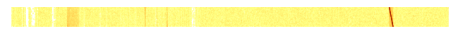

In [97]:
fish.generatemap2(g500000[80])

In [96]:
fish = heatmap_anylsis("HH_HiC200M.contact_map.mcool::/resolutions/100000")

In [ ]:
fish = heatmap_anylsis("HH_HiC200M.contact_map.mcool::/resolutions/100000")
matrix = fish.getmatrix()

In [ ]:
fish_h = heatmap_anylsis("HH_HiC200M.contact_map.mcool::/resolutions/50000")
matrix_h = fish_h.getmatrix()

In [ ]:
matrix_h.shape

In [ ]:
fish_hh = heatmap_anylsis("HH_HiC200M.contact_map.mcool::/resolutions/25000")
matrix_hh = fish_hh.getmatrix()

In [ ]:
matrix.shape

In [ ]:
fish.chro_info()

In [ ]:
fish_h.chro_info()

In [ ]:
fish.chro_info()

In [ ]:
fish_h.chro_info()

In [ ]:
matrix_h.shape

In [ ]:
matrix_hh.shape

In [ ]:
matrix

In [ ]:
matrix_h

In [ ]:
s = matrix[0:2,:]
s

In [ ]:
s1 = matrix_h[0:3,:]
s1

In [ ]:
s2 = matrix_hh[0:6,:]
s2

In [ ]:
total = 0
for i in s:
    for j in i:
        total = total + j
total
    

In [ ]:
total = 0
for i in s1:
    for j in i:
        total = total + j
total

In [ ]:
total = 0
for i in s2:
    for j in i:
        total = total + j
total

In [ ]:
plt.plot(matrix.flatten(order = 'C'))

In [ ]:
plt.plot(matrix_h.flatten(order = 'C'))

Text(0.5, 1.0, 'resolution:50000')

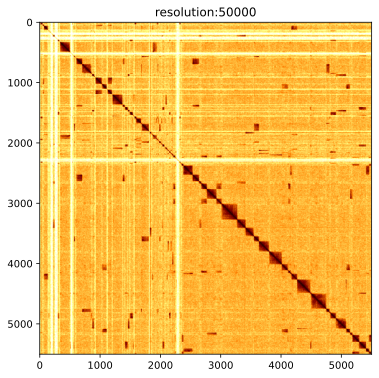

In [81]:
fish = heatmap_anylsis("HH_HiC200M.contact_map.mcool::/resolutions/100000")
fish_mat = fish.getmatrix() #get 2D Array for .cool file
all_mat = fish.split_matrix() #split matrix according contig length,return a 2D array list
all_dic = fish.split_matrix('dic') # dictionary relate contig id and 2D Array
info = fish.chro_info() #dataframe for chromosome information
start = fish.thansfer_bin_to_list('start_list')
end = fish.thansfer_bin_to_list('end_list')

fish.generatemap(fish_mat,(6,6))
plt.title('resolution:50000')




In [ ]:
fishh = fish.bins_info()

In [ ]:
fishh

In [ ]:
all_dic.get('contig_10_pilon_pilon')

In [ ]:
fish = heatmap_anylsis("HH_HiC200M.contact_map.mcool::/resolutions/100000")
fish_mat = fish.getmatrix()
fish.generatemap(fish_mat,(6,6))

In [ ]:
net_graph(new_dict)

In [ ]:
fish = heatmap_anylsis("HH_HiC200M.contact_map.mcool::/resolutions/100000")
fish_mat = fish.getmatrix()
fish.generatemap(fish_mat,(6,6))

In [ ]:
fish = heatmap_anylsis("HH_HiC200M.contact_map.mcool::/resolutions/100000")
fish_mat = fish.getmatrix()
fish.generatemap(fish_mat,(6,6))

In [ ]:
fish_mat

In [ ]:
fishh = fish.readcool()

In [ ]:
ll = tuple(x[0])

In [ ]:
np.mean(ll)

In [ ]:
g500000 = fish.remove_contig_length(500000)

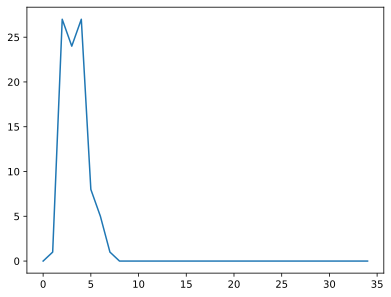

{0: 0,
 1: 1,
 2: 27,
 3: 24,
 4: 27,
 5: 8,
 6: 5,
 7: 1,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0}

In [8]:
fish.peak_plot(g500000)

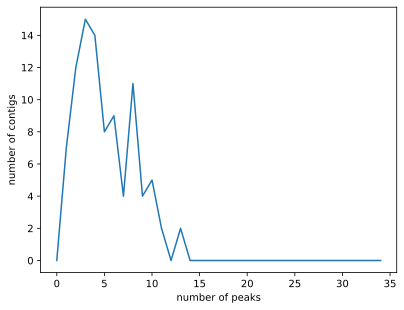

{0: 0,
 1: 7,
 2: 12,
 3: 15,
 4: 14,
 5: 8,
 6: 9,
 7: 4,
 8: 11,
 9: 4,
 10: 5,
 11: 2,
 12: 0,
 13: 2,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0}

In [44]:
peak_plot(new_dict3)

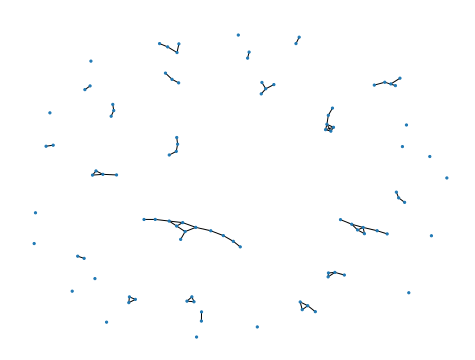

In [48]:
net_graph(new_dict2)

In [29]:
new_dict = fish.get_ids_dict(g500000,all_dic)

In [31]:
new_dict2 = fish.optimize_result(new_dict)

In [32]:
new_dict3 = sort_by_contig(info,g500000,all_dic)

In [33]:
new_dict4 = optimize_result(new_dict3,info)

In [34]:
new_dict5 = sort_by_contig_after_smooth(info,g500000,all_dic)

In [35]:
new_dict6 = optimize_result_s(new_dict5,info)

In [36]:
new_dict7 = sort_by_contig_after_filter(info,g500000,all_dic,500000)

In [37]:
new_dict8 = optimize_result_af(new_dict7)

In [38]:
new_dict9 = fish.get_ids_dict_af(g500000,all_dic)

In [39]:
new_dict10 = optimize_result_af(new_dict9)

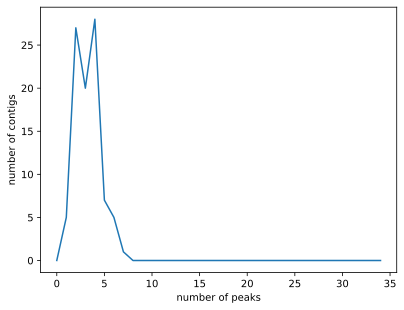

{0: 0,
 1: 5,
 2: 27,
 3: 20,
 4: 28,
 5: 7,
 6: 5,
 7: 1,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0}

In [40]:
peak_plot(new_dict)

In [ ]:
net_graph(new_dict)

In [ ]:
all_dic.get

In [ ]:
l_n_scatter(new_dict)

contig_1517_pilon_pilon
contig_825_pilon_pilon
scaffold_567_pilon_pilon
scaffold_621_pilon_pilon
scaffold_744_pilon_pilon


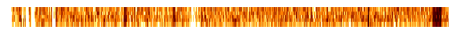

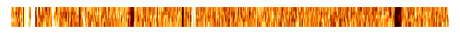

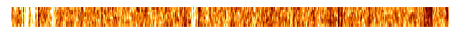

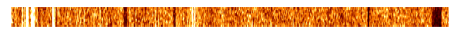

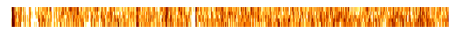

In [33]:
for key,values in new_dict.items():
    if len(values) == 6:
        length = get_length(all_dic.get(key),all_dic,'length')
        fish.generatemap2(all_dic.get(key))
        print(key)
        

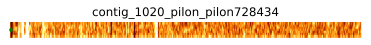

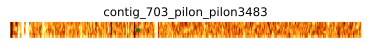

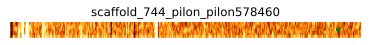

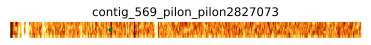

NameError: name 'new_dict2' is not defined

In [34]:
contig_1020 = all_dic.get('contig_1020_pilon_pilon')
generate_contig_peak(contig_1020,new_dict,info,all_dic)
scaffold_251 = all_dic.get('scaffold_251_pilon_pilon')
generate_contig_peak(scaffold_251,new_dict2,info,all_dic)
contig_107 = all_dic.get('contig_107_pilon_pilon')
generate_contig_peak(contig_107,new_dict,info,all_dic)
contig_745 = all_dic.get('contig_745_pilon_pilon')
generate_contig_peak(contig_745,new_dict,info,all_dic)
scaffold_580 = all_dic.get('scaffold_580_pilon_pilon')
generate_contig_peak(scaffold_580,new_dict,info,all_dic)
scaffold_7 = all_dic.get('scaffold_7_pilon_pilon')
generate_contig_peak(scaffold_7,new_dict,info,all_dic)

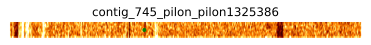

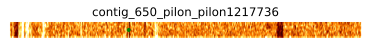

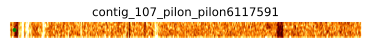

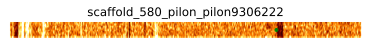

In [37]:
contig_1020 = all_dic.get('contig_650_pilon_pilon')
generate_contig_peak(contig_1020,new_dict,info,all_dic)

In [ ]:
for key,values in new_dict2.items():
    if len(values) >= 11:
        length = get_length(all_dic.get(key),all_dic,'length')
        fish.generatemap2(all_dic.get(key))
        print(key)

In [ ]:
get_score_contig_after_filter(new_dict1)


In [ ]:
#find according column detection but cannot find according contig detection
for key,values in nnn_dic.items():
    result = nnnn_dic.get(key)
    for j in values:
        if j not in result:
            print('contig ',key,' peak',j)

In [ ]:
#find according contig detection but cannot find according column detection
for key,values in nnnn_dic.items():
    result = nnn_dic.get(key)
    for j in values:
        if j not in result:
            print('contig ',key,' peak',j)
        

In [50]:
contig_650 = all_dic.get('contig_650_pilon_pilon')
contig_107 = all_dic.get('contig_107_pilon_pilon')
contig_745 = all_dic.get('contig_745_pilon_pilon')
scaffold_580 = all_dic.get('scaffold_580_pilon_pilon')
labels = np.concatenate((contig_650,contig_107,contig_745,scaffold_580), axis=0)
fish.generatemap(labels)
plt.axis('off')

(-0.5, 5502.5, 182.5, -0.5)

In [38]:
new_dict.get('contig_650_pilon_pilon')

{'contig_107_pilon_pilon',
 'contig_650_pilon_pilon',
 'contig_745_pilon_pilon',
 'scaffold_580_pilon_pilon'}

In [99]:
scaffold_580.shape

(94, 5503)

In [123]:
info.iloc[545:550,:]

,name,length,start_bin,end_bin
545,scaffold_567_pilon_pilon,889282,4113,4122
546,scaffold_576_pilon_pilon,3354985,4122,4156
547,scaffold_578_pilon_pilon,1819143,4156,4175
548,scaffold_580_pilon_pilon,9306222,4175,4269
549,scaffold_609_pilon_pilon,21660459,4269,4486


In [45]:
print(get_length(contig_650,all_dic),
get_length(contig_107,all_dic),
get_length(contig_745,all_dic),
get_length(scaffold_580,all_dic))

(1861, 1874) (73, 135) (2107, 2121) (4175, 4269)


In [111]:
x = labels[:,1861:1874]
y = labels[:,73:135]
z = labels[:,2107:2121]
o = labels[:,4175:4270]
labelss =  np.concatenate((x,y,z,o), axis=1)

In [112]:
fish.generatemap(scaffold_580)
plt.axis('off')

(-0.5, 5502.5, 93.5, -0.5)

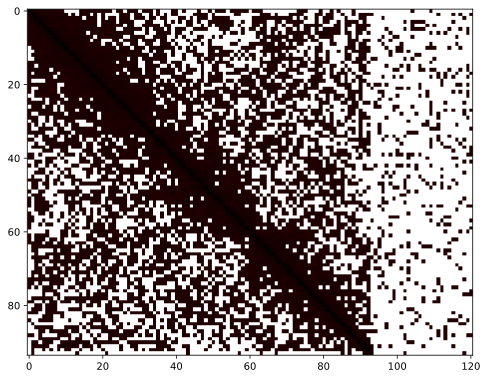

In [122]:
labelss =  np.concatenate((x,y,z), axis=1)
o = scaffold_580[:,4175:4296]
fish.generatemap(o)

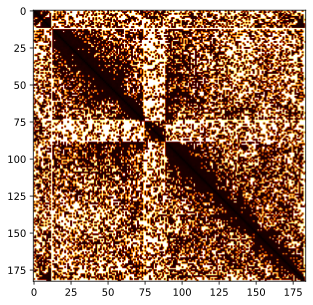

In [113]:
fish.generatemap(labelss,(5,5))

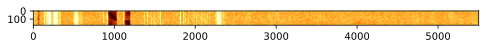

In [124]:
contig1063 = all_dic.get('contig_1063_pilon_pilon')
contig337 = all_dic.get('contig_337_pilon_pilon')
contig406 = all_dic.get('contig_406_pilon_pilon')
labels = np.concatenate((contig1063,contig337,contig406), axis=0)
fish.generatemap(labels)

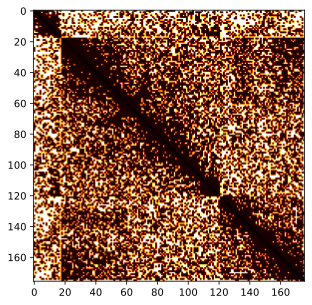

In [125]:
x = labels[:,1143:1198]
y = labels[:,927:1030]
z = labels[:,54:72]
labelss =  np.concatenate((z,y,x), axis=1)
fish.generatemap(labelss,(5,5))

In [ ]:
combo = [(x,y,z),(x,z,y),(y,x,z),(y,z,x),(z,x,y),(z,y,x)]
for i in combo:
    labelss =  np.concatenate(i, axis=1)
    fish.generatemap(labelss,(5,5))

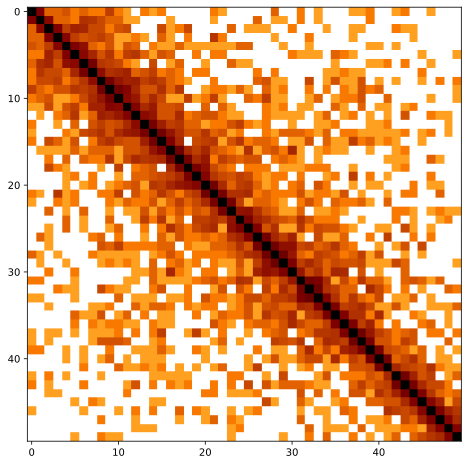

In [127]:
## get image for specific contig
c = fish.readcool()
region = 'scaffold_251_pilon_pilon:15000000-20000000'
mat = c.matrix(sparse=False, balance=False).fetch(region)
plt.figure(figsize=(8, 8))
plt.imshow(np.log10(mat), cmap='afmhot_r',norm=colors.PowerNorm(gamma=0.35))

In [1]:
## zoom in specific range in heatmap
mat = c.matrix(sparse=False, balance=False)[2900:3300,2900:3300]
plt.figure(figsize=(8, 8))
plt.imshow(mat ** 0.2, cmap='afmhot_r',norm=colors.PowerNorm(gamma=0.35))

NameError: name 'c' is not defined

In [ ]:
##get details for specific region
n = c.matrix(balance=False,as_pixels=True, join=True)[2900:3300,2900:3300]
n

In [ ]:
def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2,2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks

In [ ]:

n=5
width, height = mmmm.shape

In [ ]:
fourSums = mmmm[:-1,:-1] + mmmm[1:,:-1] + mmmm[1:,1:] + mmmm[:-1,1:]

In [ ]:
pairs = zip(arange(width*height), fourSums.flatten())

In [ ]:

def drop_overlapping(pairs):
    no_overlaps = []
    def does_not_overlap(p1, p2):
        i1, i2 = p1[0], p2[0]
        r1, col1 = i1 / (width-1), i1 % (width-1)
        r2, col2 = i2 / (width-1), i2 % (width-1)
        return (max(abs(r1-r2),abs(col1-col2)) >= 2)
    for p in pairs:
        if all(map(lambda prev: does_not_overlap(p,prev), no_overlaps)):
            no_overlaps.append(p)
    return no_overlaps

pairs2 = drop_overlapping(sorted(pairs, key=itemgetter(1), reverse=True))

# Take the first n with the heighest values

positions = pairs2[:n]

# Print results



